<a href="https://colab.research.google.com/github/nhanle83/Seattle-Rainfalls/blob/main/Excess_Rainfall_in_Seattle_2014_2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constructing a "Waterfall" Plot with the Package plotly
an assignment for SIADS 521

by Nhan Le

## Introduction

In this tutorial I discuss the process with which I constructed a "waterfall" plot with the plotly package to display precipitation pattern across the year 2014-2015 in Seattle, USA. 

The plotly package enables me to construct a waterfall plot nearly "out of a box." It also contains a diverse set of scientific plotting concepts that are not easily replicable with matplotlib or altair. It also produces plots that are automatically intereactive, although my plot for this assignment does not much benefit from this feature.  

The plot in display below combines two separate plots: the monthly average amount of precipitation in Seattle and the monthly total amount of rainfal *in excess of average*. The line plot for the monthly average precipitation shows two distinct seasons concerning precipitation: a heavily rainy season roughly between October and Apirl, which is what Seattle is well known for, and a dry season for the rest of the year. 

In contrast, the waterfall plot that tracks monthly precipitation in excess of avererage shows a distinct 4-season pattern for the 1-year 2014-2015 period: An exceptionally wet late summer-fall, followed by a below-average winter, followed by a short, wet spring, concluded by an exceptionally dry season. The total amount of precipitation of the year was no different from historical average. However, the waterfall plot displays extremel amounts of deviation from historical average percipitation throughout different months of the year. 

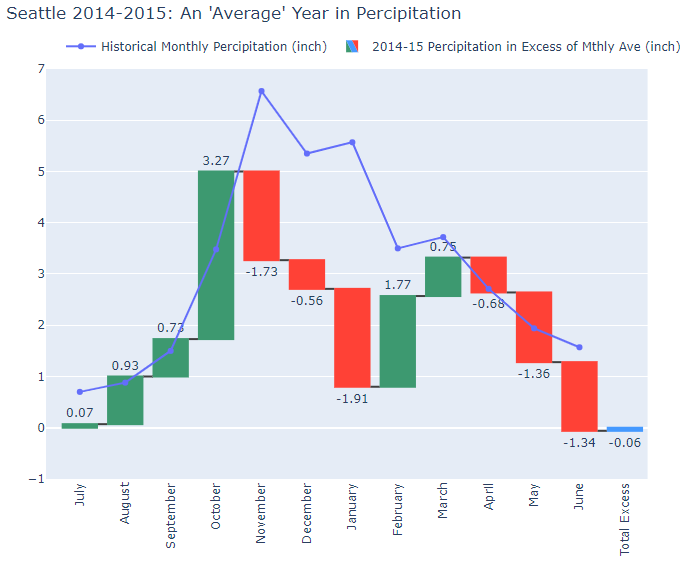

## Required packages
The code block below imports all required packages for this tutorial. Plotly is a grammar of graphic package that is available in python and other programming languages. The document for the python version is available at https://plotly.com/python/

I also include pandas, seaborn and matplotlib for convenience. Pandas is required for data cleaning and preprocessing.

This workbook is run on colab.research.google.com. All the listed packages are readily installed, so I did not have to install them.

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

# Import plotly package:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Dataset and data cleaning process

### Five38 data repo and rolling-window preprocessing for time series data

I extract Seattle weather data from Five Thirty-Eight's data repository in the URL below. 538 scraped and parsed this weather data from the website Weather Underground (www.wunderground.com)

The data contains 3 variables of interest:

- Date (daily frequency)
- Actual precipitation (inch)
- (Historical) Average precipitation (inch)

I drew quick time series plot for actual precipitation and learned that the data needed much pre-processing to be visualized effectively: By nature, the bulk of precipitation of a year fall in a few heavy days while most days (even in Seattle!) have 0 precipitation. 

A standard treatment for time series with unpredictable and frequent fluctuation is to calculate rolling-window average. In the second plot of this section, I tried 7-day and 30-day rolling-window average precipitation and compared them with historical daily average. The 30-day rolling window result in a much more visually useful time seies than 7-day rolling window, enabling direct comparison with historical daily average. Despite some volatiliy in the plot, fall 2014 and summer 2015 clearly emerged as exceptionally dry compared to historical average.

It is still difficult, however, to judge whether the year in consideration was drier or wetter than the average year in Seattle history. For this I will explore a combination of different techniques in the next subsection.



In [53]:
weather_data = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/us-weather-history/KSEA.csv', parse_dates=['date'])
print(weather_data.describe())

# explore rain data
rain_cols = ['date']+list(weather_data.columns)[-3:]
rain = weather_data[rain_cols]
print(rain.info())

       actual_mean_temp  ...  record_precipitation
count        365.000000  ...            365.000000
mean          56.542466  ...              1.107178
std           10.437226  ...              0.648280
min           30.000000  ...              0.110000
25%           49.000000  ...              0.660000
50%           56.000000  ...              0.960000
75%           65.000000  ...              1.410000
max           80.000000  ...              5.020000

[8 rows x 12 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   365 non-null    datetime64[ns]
 1   actual_precipitation   365 non-null    float64       
 2   average_precipitation  365 non-null    float64       
 3   record_precipitation   365 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.5 KB


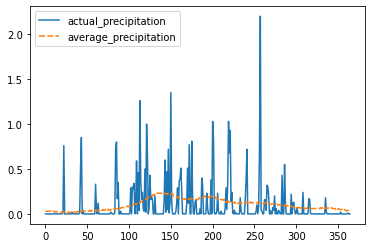

In [54]:
g1=sns.lineplot(data = rain.iloc[:, :3])

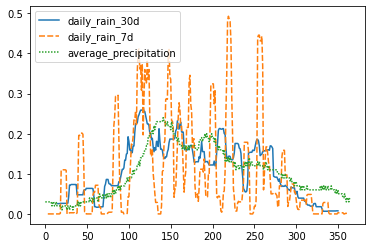

In [55]:
# Compute the centered 7-day rolling mean for 'actual_preciptation'
rain['daily_rain_7d'] = rain['actual_precipitation'].rolling(7, center=True).mean()
rain['daily_rain_30d'] = rain['actual_precipitation'].rolling(30, center=True).mean()
g1_1=sns.lineplot(data = rain[['daily_rain_30d','daily_rain_7d', 'average_precipitation']])

### Data cleaning: monthly "down-sampling" and comparison with historical average

I am interested in comparing the year in question to historical average. To do this I subtract each day's actual precipitation from respective daily historical average (variable "Rainfall excess" in the dataframe).

In addition, A different technique to reduce volatility from time series data is down-sampling the data from daily frequency to, in this case, monthly frequency. The month is rather an arbitrary time unit, but it has a widely recognized set of names that can be easily referred to for discussion purpose. For this tutorial, I down-sample simply by adding up all daily observations. 

The dataframe "source" stores the final version of the data to be plotted. Its unit of observation is the month. Its two main variables are:
- Total monthly precipitation in excess of monthly average
- Historical monthly average precipitation

In [56]:
# how does rain deviate from historical average over the year?
rain['Excess Rainfall'] = rain['actual_precipitation'] - rain['average_precipitation']
# cumulative rainfall relative to year
rain['Cumulative Excess Rainfall'] = rain['Excess Rainfall'].cumsum()
# how does rainfall change from month to month?
rain['month'] = rain['date'].dt.month

# need to sort month from july to june:
m_order = [7, 8, 9, 10, 11, 12, 1 , 2, 3, 4, 5, 6]
rain['month'] = pd.Categorical(rain['month'], ordered=True, categories=m_order)

In [57]:
rain.columns

Index(['date', 'actual_precipitation', 'average_precipitation',
       'record_precipitation', 'daily_rain_7d', 'daily_rain_30d',
       'Excess Rainfall', 'Cumulative Excess Rainfall', 'month'],
      dtype='object')

In [58]:
source = rain.groupby('month')[['Excess Rainfall','average_precipitation']].sum().reset_index()
source

,month,Excess Rainfall,average_precipitation
0,7,0.07,0.70
1,8,0.93,0.88
2,9,0.73,1.50
3,10,3.27,3.48
4,11,-1.73,6.57
5,12,-0.56,5.35
6,1,-1.91,5.57
7,2,1.77,3.50
8,3,0.75,3.72
9,4,-0.68,2.71


## The final plot and a brief intro to the grammar of graphic of plotly
I begin this section with the code and plot for the final version of the plot that I chose to present the data.

The way I learned to use plotly is simply exploring their gallery and experimenting with their code until I managed to produce what I wanted: https://plotly.com/r/waterfall-charts/

In [45]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig1 = go.Waterfall(
    # orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "relative", "relative",
               "relative", "relative", "relative", "relative", "relative", "relative","total"],
    x = ['July', 'August', 'September', 'October', 'November', 'December', 
          'January', 'February', 'March', 'April', 'May', 'June', 'Total Excess'],
    textposition = "outside",
    text = [str(round(x,2)) for x in list(source['Excess Rainfall'])]+ \
            [str(round(sum(source['Excess Rainfall']),3))],
    y = list(source['Excess Rainfall'])+[0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
    name = "2014-15 Percipitation in Excess of Mthly Ave (inch)"
)


fig2 = go.Scatter(
    x=['July', 'August', 'September', 'October', 'November', 'December', 
          'January', 'February', 'March', 'April', 'May', 'June'],
    y=source['average_precipitation'],
    text = [str(round(x,2)) for x in list(source['average_precipitation'])],
    name='Historical Monthly Percipitation (inch)',
    yaxis='y2'

)

# fig.update_layout(
#     title = "Seattle 2014-2015: Rainfall in Excess of Monthly Average (inches)",
#     showlegend = False,
#     autosize=False,
#     width=800,
#     height=600
# )

# fig.show()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(fig2,secondary_y=False)
fig.add_trace(fig1)

fig.update_layout(
    height = 600, width = 800,
    title = "Seattle 2014-2015: An 'Average' Year in Percipitation",
    xaxis=dict(
      tickangle=-90
    ),
    yaxis_range=[-1,7],
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
go.Figure(fig)

The code block below strips my code down to onlyt the essential parts:

- The command go.Waterfall() creates a graph object using the graph_object command of plotly. Input this object in the command print() shows us the components of the graph object. In this example, the object has a particular graph type: ```Waterfall```.
- There are 3 essential component for each Waterfall graph object (all others, commented out, are optional):
  + ```x=``` A list of labels in the x-asix for columns in the graph
  + ```y=``` A list of numerical values for how tall the columns (+ or -) are in the graph.
  + ```measure=``` A list of indictors whether to place the columns *relative* to the previous column values or as a *total* of the previous values.

I would note that because this plotly graph does little data processing, it is essential that users are able to preprocess the data in the "cleaning" step to match the concept behind the Waterfall graph. In practice, I browsed 

In [60]:
fig1 = go.Waterfall(
    # orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "relative", "relative",
               "relative", "relative", "relative", "relative", "relative", "relative","total"],
    x = ['July', 'August', 'September', 'October', 'November', 'December', 
          'January', 'February', 'March', 'April', 'May', 'June', 'Total Excess'],
    # textposition = "outside",
    # text = [str(round(x,2)) for x in list(source['Excess Rainfall'])]+ \
    #         [str(round(sum(source['Excess Rainfall']),3))],
    y = list(source['Excess Rainfall'])+[0],
    # connector = {"line":{"color":"rgb(63, 63, 63)"}},
    # name = "2014-15 Percipitation in Excess of Mthly Ave (inch)"
)

print(fig1)
go.Figure(fig1)

Waterfall({
    'measure': [relative, relative, relative, relative, relative, relative,
                relative, relative, relative, relative, relative, relative, total],
    'x': [July, August, September, October, November, December, January, February,
          March, April, May, June, Total Excess],
    'y': [0.06999999999999976, 0.9299999999999995, 0.7299999999999995, 3.27,
          -1.73, -0.5600000000000006, -1.9099999999999995, 1.7699999999999987,
          0.7499999999999998, -0.6799999999999999, -1.3600000000000008,
          -1.3400000000000007, 0]
})


Once a graph object is created, it can be displayed by the command ```go.Figure()```. "Go figure!" was how I felt the first time I learned grammar graphic. Pun intended (It was in R).

This grammar of graphic enables coders to configure the graph with important details such as titles, labels and tick marks, and design the graph to be more aesthetically pleasing. To do this, coders use the method ```.update_layout()```. For example, I want to set the size for my graph before displaying it:

In [62]:
go.Figure(fig1).update_layout(height = 600, width = 800)

The grammar of graphic of plotly also enables me to *layer* 2 or more plots in one final graphic while matching any axis or label that they have in common. For example, layering `fig1` and `fig2` can be as simple as:

In [65]:
fig = make_subplots(specs=[[{"secondary_y": True}]]) 
fig.add_trace(fig2,secondary_y=False) # ,secondary_y=False optional but needed to unify the 2 y-axes
fig.add_trace(fig1)

go.Figure(fig)

## Conclusion:

For me the biggest revelation when learning plotly was the diversities of plot types that it offers. These plots offer different statistical concepts, which enables thinking about the data in different ways. I think this is the decisive advantage of plotly over matplotlib and altair. 

The instruction team should consider skipping matplotlib in the next run of the course. Why start out with the basic when nothing will stop you from playing with magic right away?

## Appendix: Behind-the-scene exploratoration with seaborn

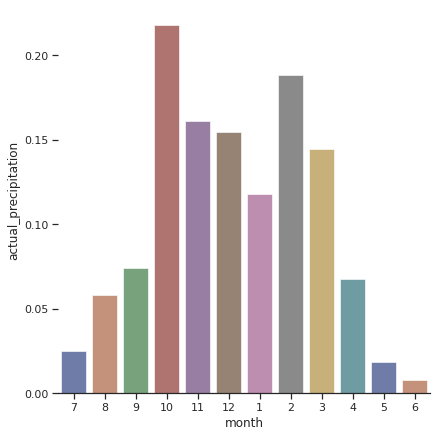

In [20]:
g7 = sns.catplot(
    data=rain, kind="bar",
    x="month", y='actual_precipitation',
    ci=None, 
    palette="dark", alpha=.6, height=6
)
sns.despine(left=True)

Text(0.5, 1.0, 'Daily Rainfall Distribution')

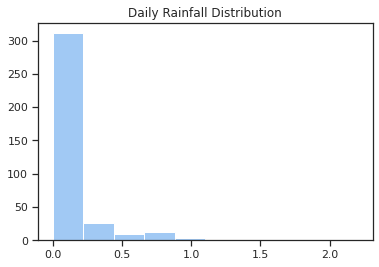

In [14]:
plt.figure()
plt.hist(weather_data['actual_precipitation'].values)
plt.title('Daily Rainfall Distribution')


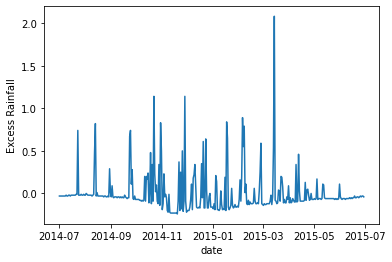

In [6]:
g2=sns.lineplot(y='Excess Rainfall', x='date', data = rain)

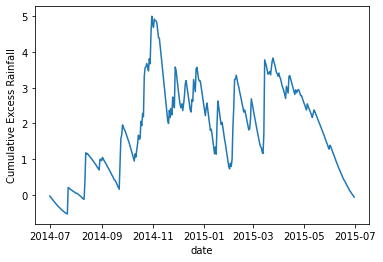

In [7]:

g3=sns.lineplot(y='Cumulative Excess Rainfall', x='date', data = rain)

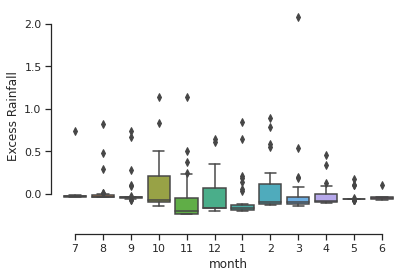

In [10]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# draw boxplot
g5=sns.boxplot(x="month", y="Excess Rainfall",
            data=rain)
sns.despine(offset=10, trim=True)

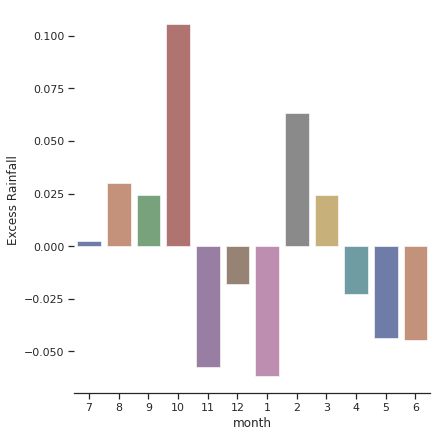

In [11]:
# Draw a rainfall barplot by month
g6 = sns.catplot(
    data=rain, kind="bar",
    x="month", y="Excess Rainfall",
    ci=None, 
    palette="dark", alpha=.6, height=6
)
sns.despine(left=True)

In [ ]:
# define drought as n-day streak with rainfalls of p or lower
# report the drought periods
p = 0.1
rain['drought'] = rain['actual_precipitation'] < p
rain['grouper'] = (rain.drought != rain.drought.shift()).cumsum()
rain['streak'] = rain['drought'].groupby(grouper).cumsum()
rain.head(10)
for i, g in rain.groupby('grouper'):
    if len(g.date.tolist()) >20:
      print ("First day of dought: {}. Drought duration: {}".format(g.date.tolist()[0],len(g.date.tolist())))
      print("Average rain per day: {}. Total accumulation: {}".format(round(g.actual_precipitation.mean(), 3), round(g.actual_precipitation.sum(),3)))

First day of dought: 2014-07-01 00:00:00. Drought duration: 22
Average rain per day: 0.0. Total accumulation: 0.01
First day of dought: 2015-06-02 00:00:00. Drought duration: 29
Average rain per day: 0.002. Total accumulation: 0.05
